# CareerCon 2019 - Help Navigate Robots
## Robots are smart… by design !!


Robots are smart… by design. To fully understand and properly navigate a task, however, they need input about their environment.

In this competition, you’ll help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).

We’ve collected IMU sensor data while driving a small mobile robot over different floor surfaces on the university premises. The task is to predict which one of the nine floor types (carpet, tiles, concrete) the robot is on using sensor data such as acceleration and velocity. Succeed and you'll help improve the navigation of robots without assistance across many different surfaces, so they won’t fall down on the job.

###  Its a golden chance to help humanity, by helping Robots !

**X_[train/test].csv** - the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns:

- ```row_id```: The ID for this row.

- ```series_id: ID``` number for the measurement series. Foreign key to y_train/sample_submission.

- ```measurement_number```: Measurement number within the series.

The orientation channels encode the current angles how the robot is oriented as a quaternion (see Wikipedia). Angular velocity describes the angle and speed of motion, and linear acceleration components describe how the speed is changing at different times. The 10 sensor channels are:

```
orientation_X

orientation_Y

orientation_Z

orientation_W

angular_velocity_X

angular_velocity_Y

angular_velocity_Z

linear_acceleration_X

linear_acceleration_Y

linear_acceleration_Z
```

**y_train.csv** - the surfaces for training set.

- ```series_id```: ID number for the measurement series.

- ```group_id```: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies.

- ```surface```: the target for this competition.

**sample_submission.csv** - a sample submission file in the correct format.

### Load packages

In [1]:
import numpy as np 
import pandas as pd 
import os
from time import time
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
from numba import jit
import itertools
from seaborn import countplot,lineplot, barplot
from numba import jit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.style as style 
style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
import gc
gc.enable()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Load data

In [2]:
data = pd.read_csv('input/X_train.csv')
tr = pd.read_csv('input/X_train.csv')
sub = pd.read_csv('input/sample_submission.csv')
test = pd.read_csv('input/X_test.csv')
target = pd.read_csv('input/y_train.csv')
print ("Data is ready !!")

Data is ready !!


# Data exploration

In [4]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [ ]:
test.head()

In [16]:
#target.head()
# Printing unique values in our dataset
print(test.nunique())

row_id                   488448
series_id                  3816
measurement_number          128
orientation_X            160946
orientation_Y            149728
orientation_Z            121701
orientation_W            138668
angular_velocity_X       159433
angular_velocity_Y       150410
angular_velocity_Z       202351
linear_acceleration_X    243392
linear_acceleration_Y    112608
linear_acceleration_Z     73231
dtype: int64


In [ ]:
len(data.measurement_number.value_counts())

Each series has 128 measurements. 

**1 serie = 128 measurements**. 

For example, serie with series_id=0 has a surface = *fin_concrete* and 128 measurements.

### describe (basic stats)

In [9]:
data.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [10]:
test.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098435,-0.037396,-0.029865,-0.089842,-0.486233,2.052100,-10.125000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000


In [11]:
target.describe()

,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


### There is missing data in test and train data

In [12]:
totalt = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
print ("Missing Data at Training")
missing_data.tail()

Missing Data at Training


,Total,Percent
orientation_Y,0,0.0
orientation_X,0,0.0
measurement_number,0,0.0
series_id,0,0.0
row_id,0,0.0


In [13]:
totalt = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
print ("Missing Data at Test")
missing_data.tail()

Missing Data at Test


,Total,Percent
orientation_Y,0,0.0
orientation_X,0,0.0
measurement_number,0,0.0
series_id,0,0.0
row_id,0,0.0


In [14]:
print ("Test has ", (test.shape[0]-data.shape[0])/128, "series more than Train (later I will prove it) = 768 registers")
dif = test.shape[0]-data.shape[0]
print ("Let's check this extra 6 series")
test.tail(768).describe() #6*128=768 last rows

Test has  6.0 series more than Train (later I will prove it) = 768 registers
Let's check this extra 6 series


,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3812.500000,63.500000,-0.227899,0.616574,0.090341,-0.038248,-0.003022,-0.027497,0.103820,0.170629,2.832722,-9.351470
std,1.708938,36.973369,0.679676,0.290854,0.048516,0.100461,0.095879,0.079114,0.222543,1.383624,2.212012,2.049869
min,3810.000000,0.000000,-0.981070,0.123660,0.008861,-0.148810,-0.517050,-0.218150,-0.344380,-11.605000,-5.562500,-23.692000
25%,3811.000000,31.750000,-0.943065,0.297930,0.038173,-0.142825,-0.038473,-0.066248,-0.063214,-0.432255,2.031675,-10.113250
50%,3812.500000,63.500000,-0.297575,0.724580,0.105996,-0.049340,-0.007357,-0.011478,0.057392,0.184680,2.972200,-9.334750
75%,3814.000000,95.250000,0.557312,0.816645,0.129050,0.079957,0.041774,0.026707,0.171278,0.818900,3.914600,-8.663825
max,3815.000000,127.000000,0.591450,0.978060,0.148450,0.083127,0.414210,0.291390,0.575400,8.387500,8.958900,4.328300


If we look at the features: orientation, angular velocity and linear acceleration, we can see big differences between **max** and **min** from entire test vs 6 extra test's series (see **linear_acceleration_Z**).

Obviously we are comparing 3810 series vs 6 series so this is not a big deal.

### goup_id will be important !!

In [43]:
target.groupby('group_id').surface.nunique().max()

1

In [18]:
target['group_id'].nunique()

73

**73 groups**
**Each group_id is a unique recording session and has only one surface type **

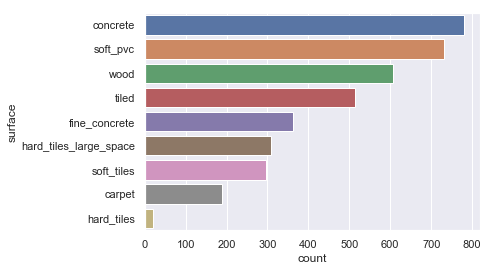

In [19]:
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = target,
              order = target['surface'].value_counts().index)
plt.show()

### Target feature - surface and group_id distribution
Let's show now the distribution of target feature - surface and group_id.
by @gpreda.

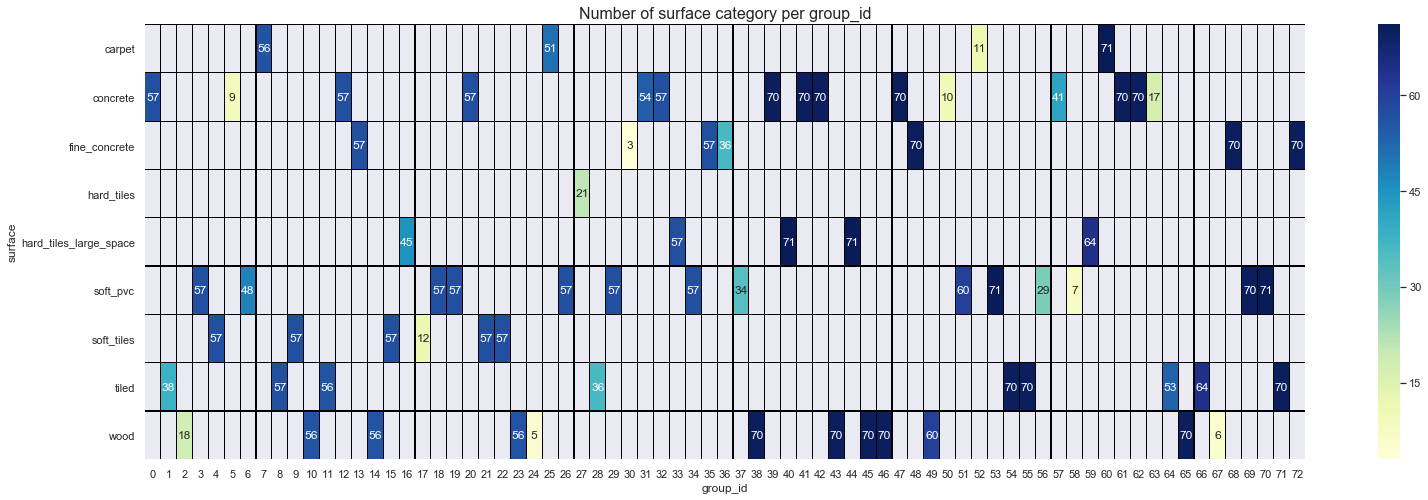

In [20]:
fig, ax = plt.subplots(1,1,figsize=(26,8))
tmp = pd.DataFrame(target.groupby(['group_id', 'surface'])['series_id'].count().reset_index())
m = tmp.pivot(index='surface', columns='group_id', values='series_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of surface category per group_id', size=16)
plt.show()

We need to classify on which surface our robot is standing.

Multi-class Multi-output

9 classes (suface)

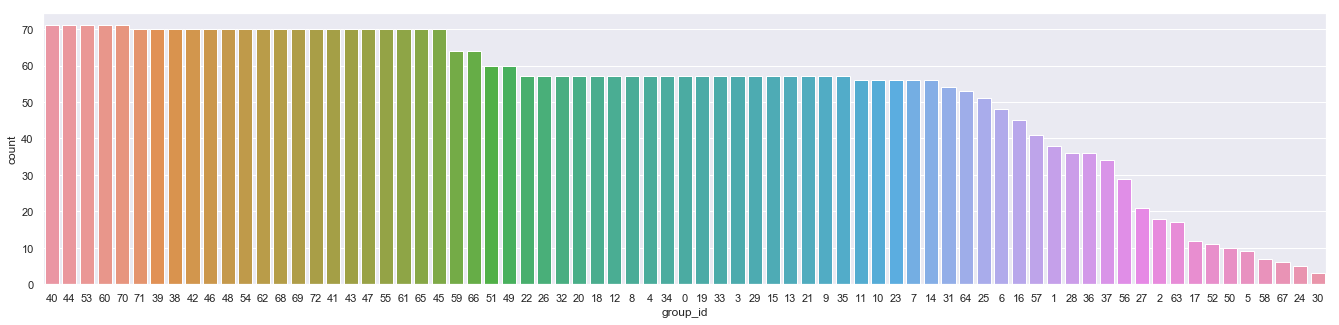

In [21]:
plt.figure(figsize=(23,5)) 
sns.set(style="darkgrid")
countplot(x="group_id", data=target, order = target['group_id'].value_counts().index)
plt.show()

**So, we have 3810 train series, and 3816 test series.
Let's engineer some features!**

## Example: Series 1

Let's have a look at the values of features in a single time-series, for example series 1  ```series_id=0```

Click to see all measurements of the **first series** 

In [22]:
serie1 = tr.head(128)
serie1.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [23]:
serie1.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,0.0,63.500000,-0.758666,-0.634008,-0.105474,-0.106470,-0.002481,-0.003306,0.007532,0.263418,2.984195,-9.320391
std,0.0,37.094474,0.000363,0.000471,0.000432,0.000389,0.052800,0.031544,0.017127,0.911175,1.387790,1.095040
min,0.0,0.000000,-0.759530,-0.634560,-0.106140,-0.107050,-0.160410,-0.079404,-0.030181,-1.864400,0.075417,-12.512000
25%,0.0,31.750000,-0.758927,-0.634383,-0.105873,-0.106775,-0.029069,-0.027110,-0.005289,-0.362872,1.791050,-9.875850
50%,0.0,63.500000,-0.758530,-0.634270,-0.105500,-0.106555,-0.005082,-0.004037,0.006842,0.231665,3.407550,-9.429950
75%,0.0,95.250000,-0.758367,-0.633530,-0.105077,-0.106130,0.035803,0.020031,0.020088,0.905635,4.119200,-8.633425
max,0.0,127.000000,-0.758220,-0.633060,-0.104610,-0.105590,0.107650,0.072698,0.051720,2.853800,5.386400,-6.268100


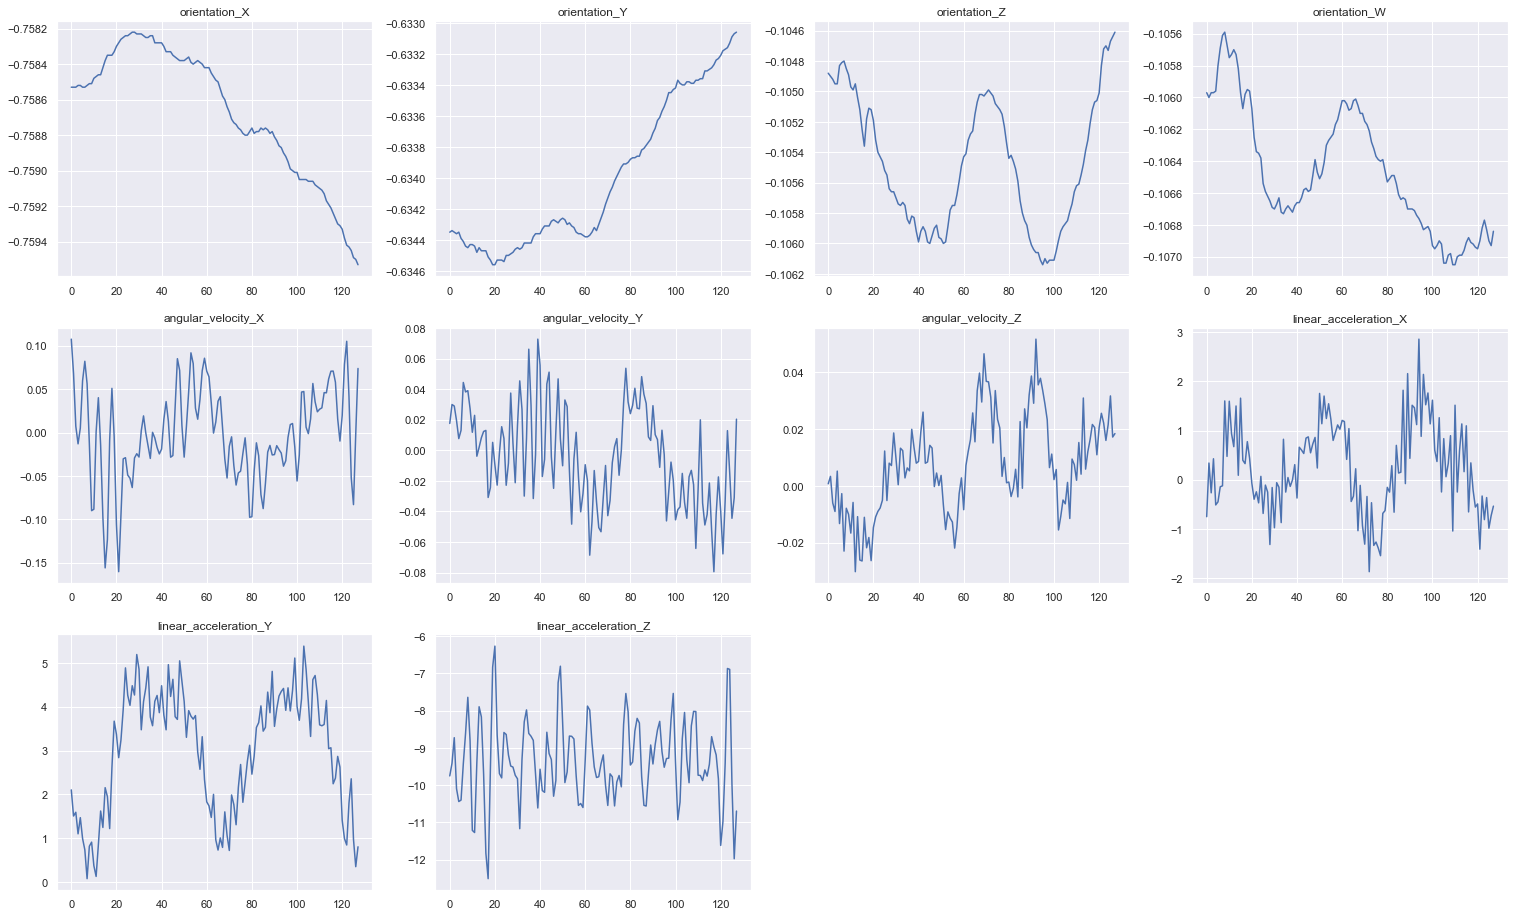

In [24]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(serie1.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(serie1[col])
    plt.title(col)

In this example, we can see a quite interesting performance:
1. Orientation X increases
2. Orientation Y decreases
3. We don't see any kind of pattern except for linear_acceleration_Y

And we know that in this series, the robot moved throuh "fine_concrete".

In [25]:
target.head(1)

,series_id,group_id,surface
0,0,13,fine_concrete


In [26]:
del serie1
gc.collect()

33799

## Visualizing Series

Before, I showed you as an example the series 1.

**This code allows you to visualize any series.**

From: *Code Snippet For Visualizing Series Id by @shaz13*

In [27]:
series_dict = {}
for series in (data['series_id'].unique()):
    series_dict[series] = data[data['series_id'] == series]

In [28]:
def plotSeries(series_id):
    style.use('ggplot')
    plt.figure(figsize=(28, 16))
    print(target[target['series_id'] == series_id]['surface'].values[0].title())
    for i, col in enumerate(series_dict[series_id].columns[3:]):
        if col.startswith("o"):
            color = 'red'
        elif col.startswith("a"):
            color = 'green'
        else:
            color = 'blue'
        if i >= 7:
            i+=1
        plt.subplot(3, 4, i + 1)
        plt.plot(series_dict[series_id][col], color=color, linewidth=3)
        plt.title(col)

**Now, Let's see code for series 15 ( is an example, try what you want)**

Carpet


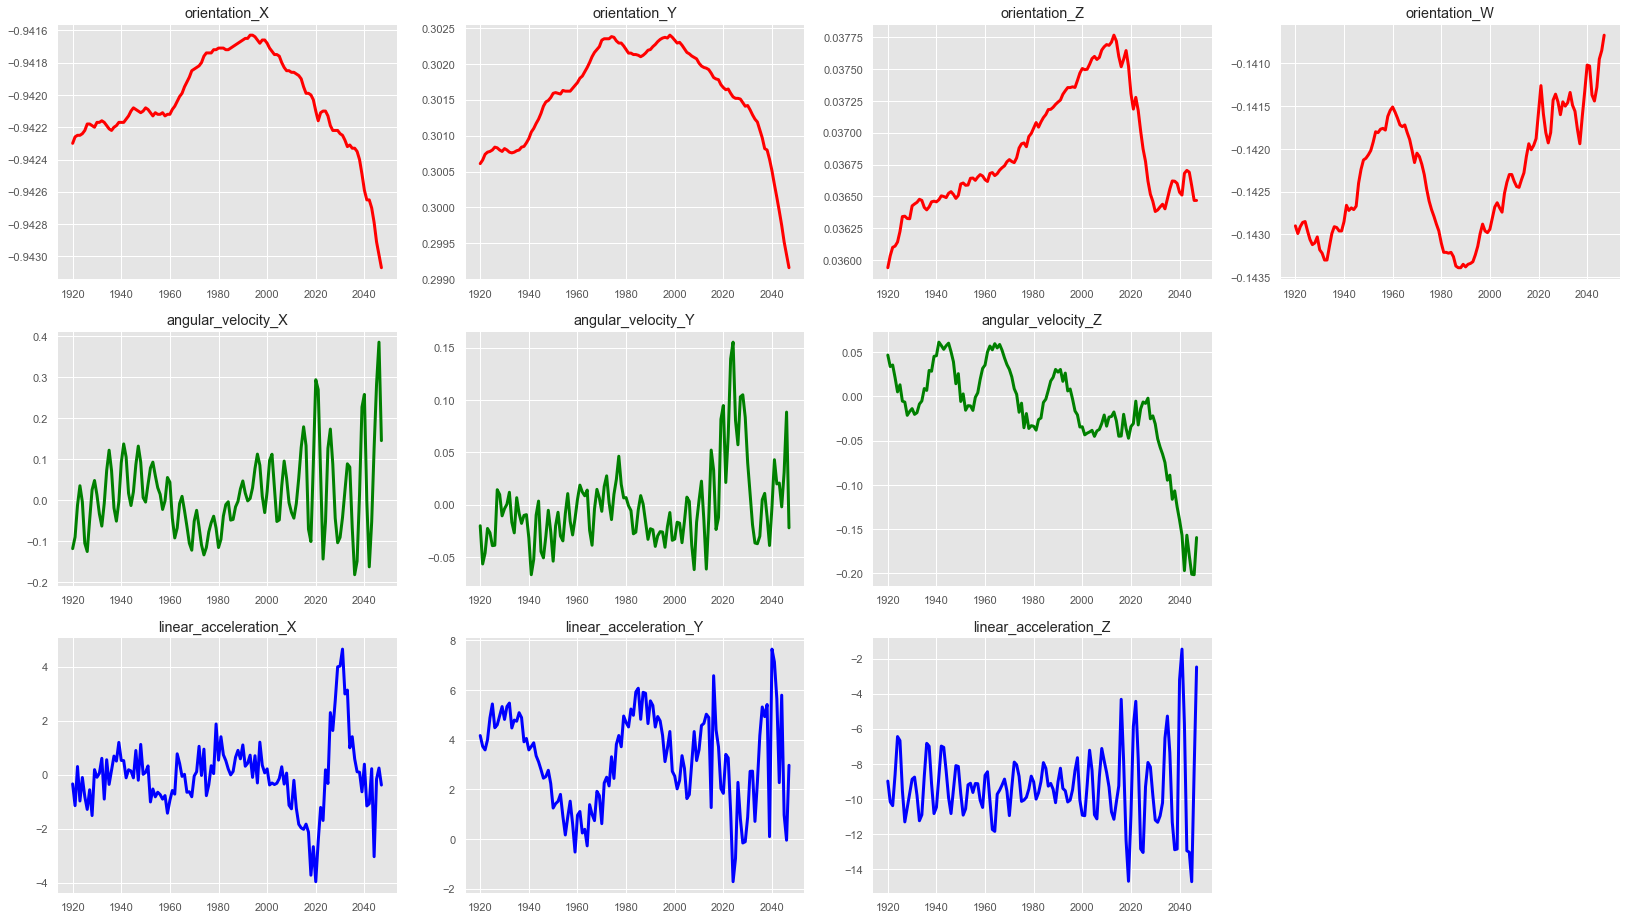

In [29]:
id_series = 15
plotSeries(id_series)

In [30]:
del series_dict
gc.collect()

21302

<br>
### Correlations (Part I)

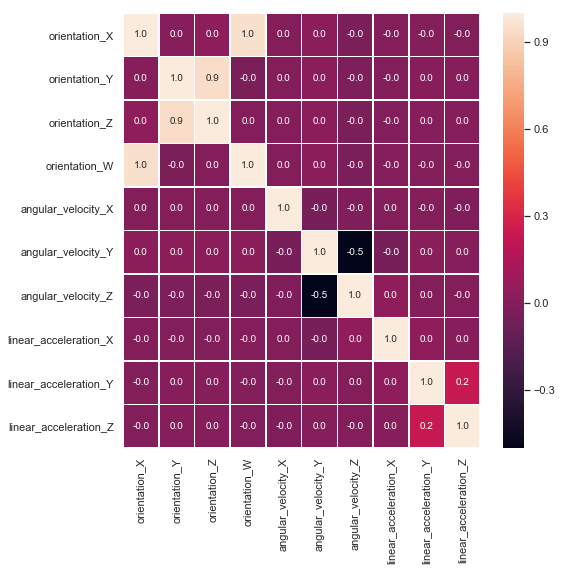

In [44]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(tr.iloc[:,3:].corr(method='kendall'), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

**Correlations test (click "code")** 

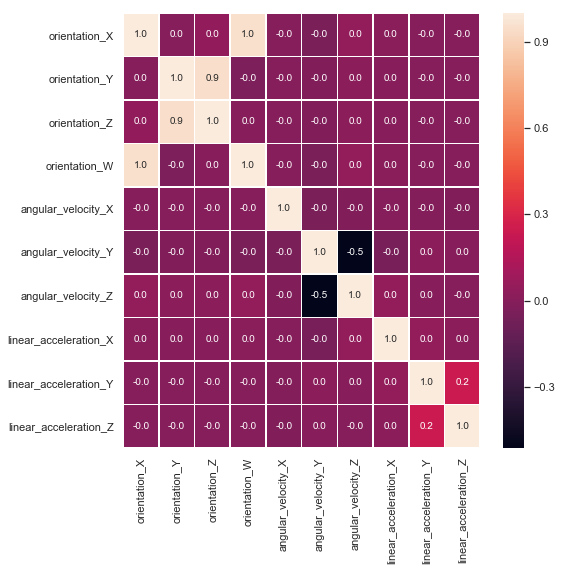

In [45]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(test.iloc[:,3:].corr(method='kendall'), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Well, this is immportant, there is a **strong correlation** between:
- angular_velocity_Z and angular_velocity_Y
- orientation_X and orientation_Y
- orientation_Y and orientation_Z

Moreover, test has different correlations than training, for example:

- angular_velocity_Z and orientation_X: -0.1(training) and 0.1(test). Anyway, is too small in both cases, it should not be a problem.

---

# Feature Engineering

In [48]:
data.columns.values[3:]

array(['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W',
       'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
       'linear_acceleration_X', 'linear_acceleration_Y',
       'linear_acceleration_Z'], dtype=object)

In [33]:
def plot_feature_distribution(df1, df2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

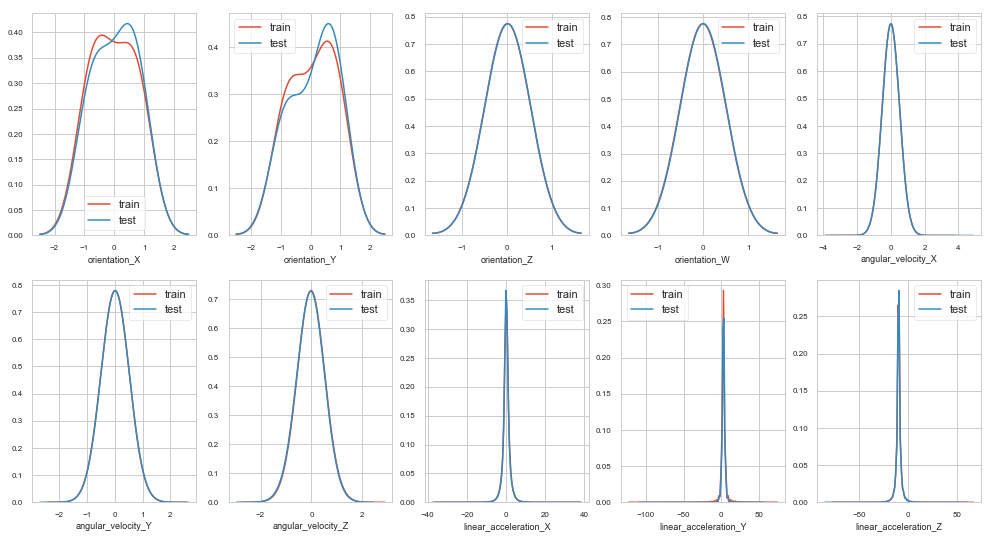

In [34]:
features = data.columns.values[3:]
plot_feature_distribution(data, test, 'train', 'test', features)

Godd news, our basic features have the **same distribution (Normal) on test and training**. There are some differences between *orientation_X* , *orientation_Y* and *linear_acceleration_Y*.

I willl try **StandardScaler** to fix this, and remember: orientation , angular velocity and linear acceleration are measured with different units, scaling might be a good choice.

In [35]:
def plot_feature_class_distribution(classes,tt, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

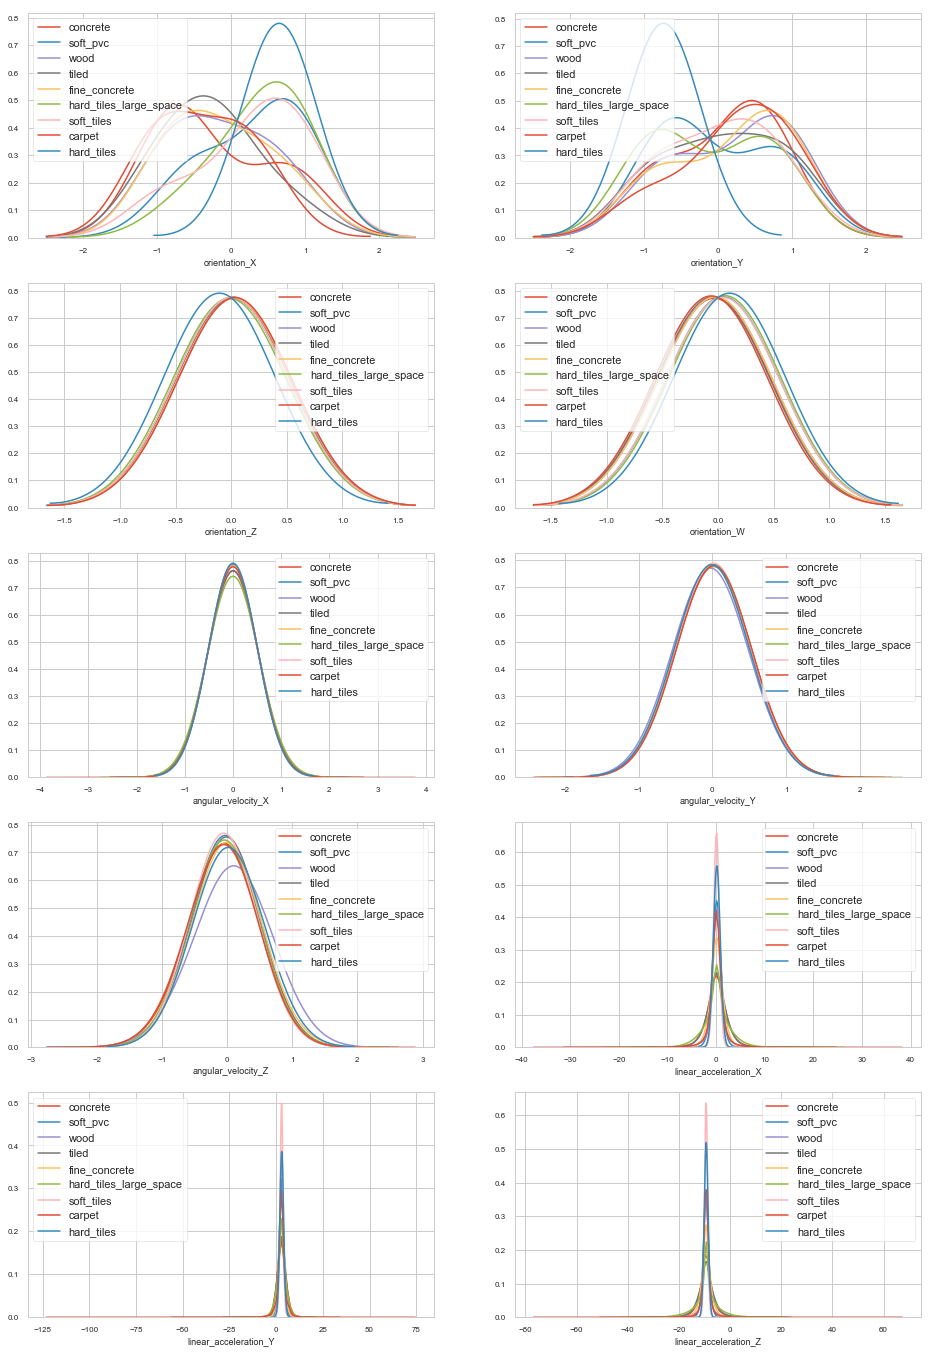

In [36]:
classes = (target['surface'].value_counts()).index
aux = data.merge(target, on='series_id', how='inner')
plot_feature_class_distribution(classes, aux, features)

**Normal distribution**

There are obviously differences between *surfaces* and that's good, we will focus on that in order to classify them better.

Knowing this differences and that variables follow a normal distribution (in most of the cases) we need to add new features like: ```mean, std, median, range ...``` (for each variable).

However, I will try to fix *orientation_X* and *orientation_Y* as I explained before, scaling and normalizing data.

---

### Now with a new scale (more more precision)

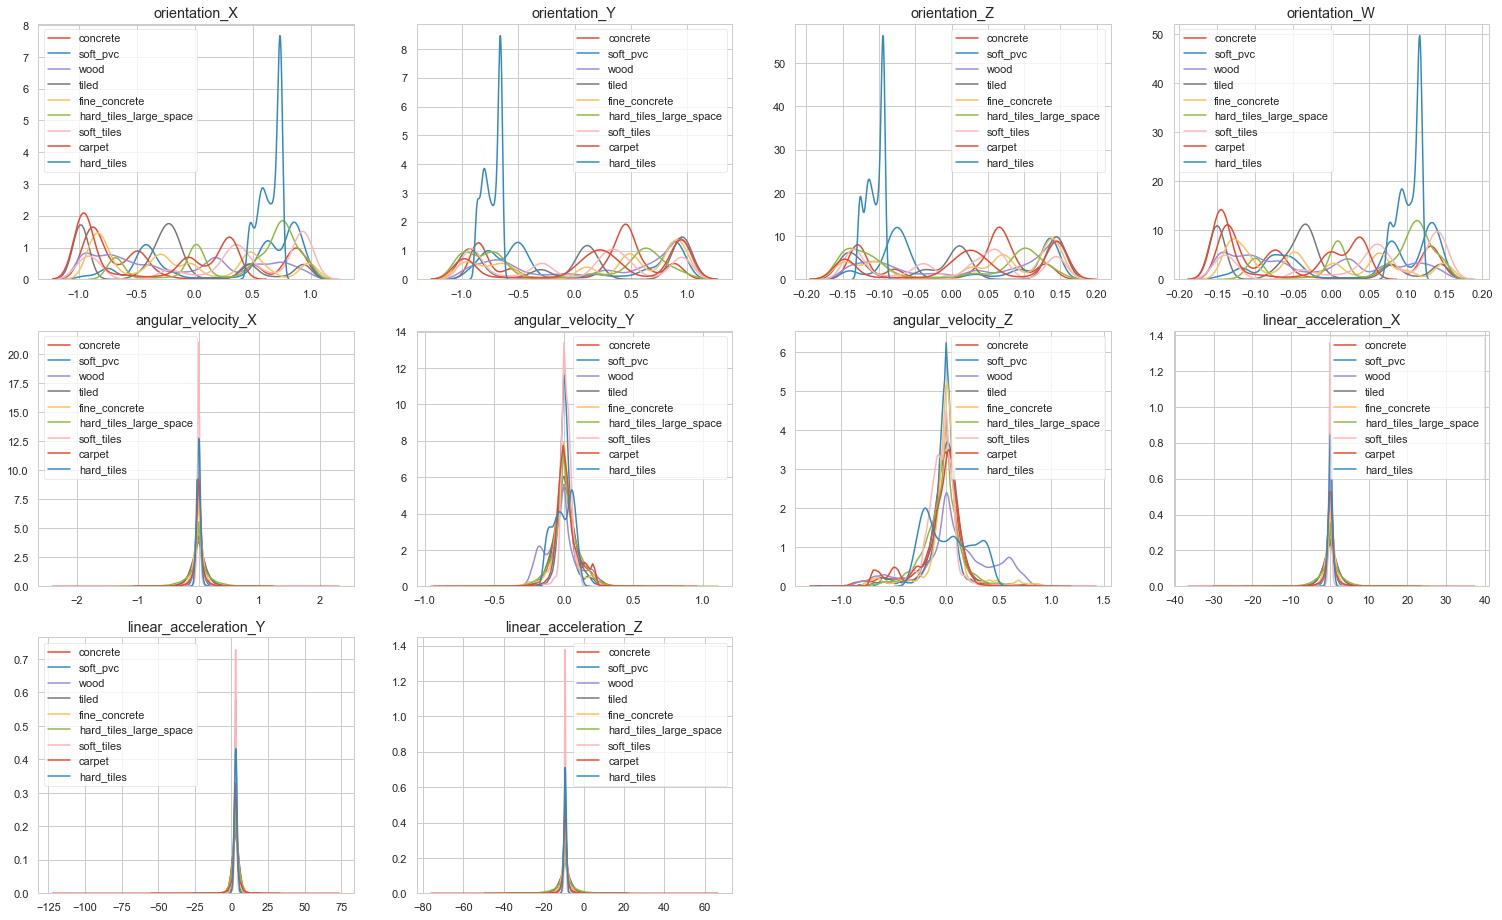

In [37]:
plt.figure(figsize=(26, 16))
for i,col in enumerate(aux.columns[3:13]):
    ax = plt.subplot(3,4,i+1)
    ax = plt.title(col)
    for surface in classes:
        surface_feature = aux[aux['surface'] == surface]
        sns.kdeplot(surface_feature[col], label = surface)

### Histogram for main features

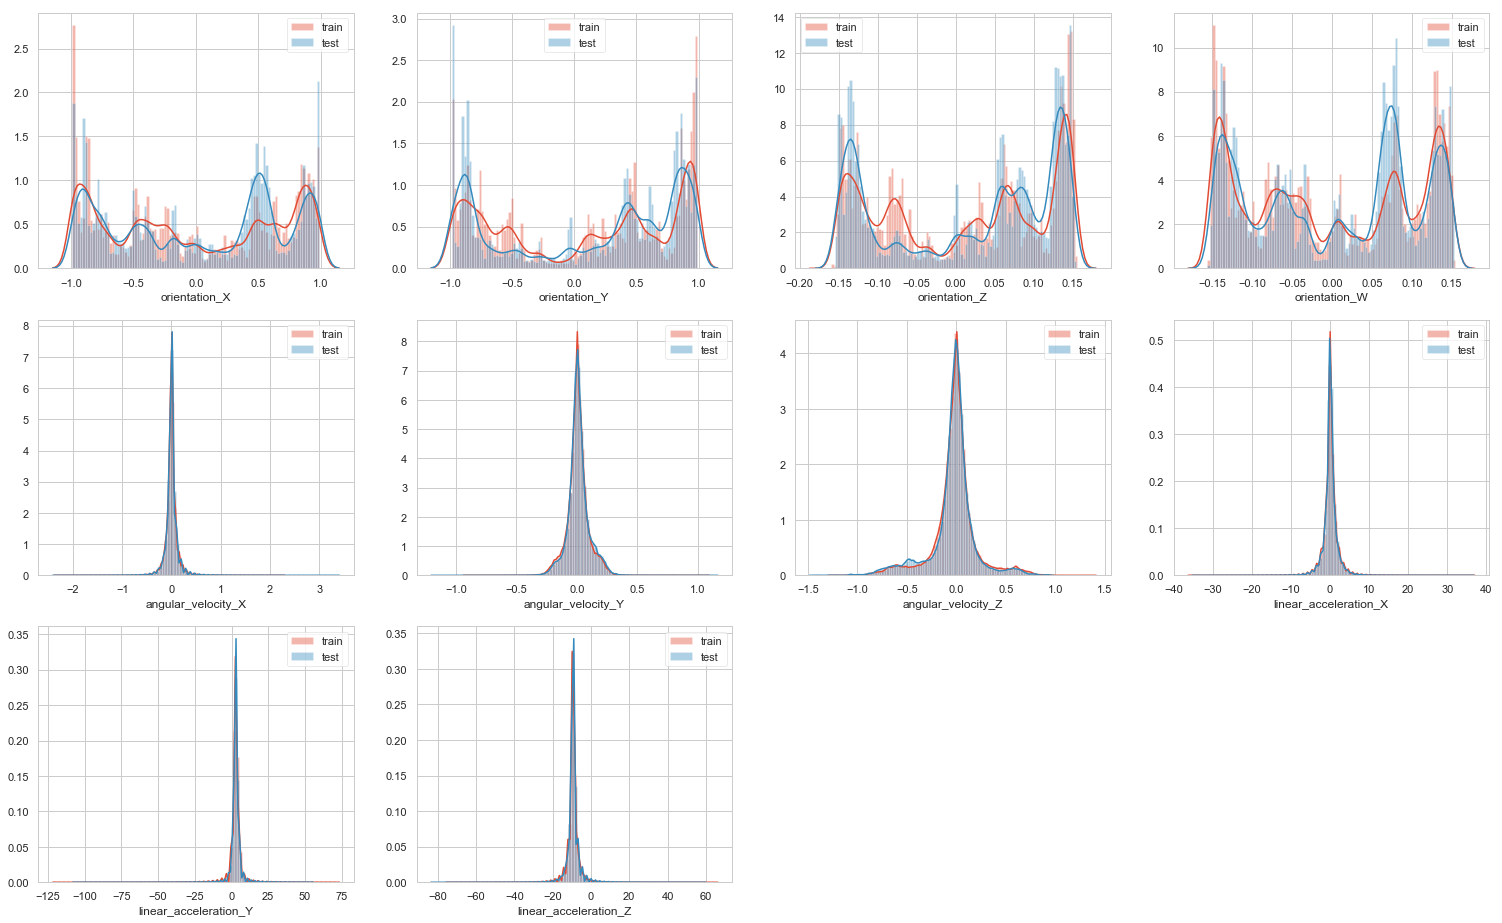

In [38]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(data.columns[3:]):
    ax = plt.subplot(3, 4, i + 1)
    sns.distplot(data[col], bins=100, label='train')
    sns.distplot(test[col], bins=100, label='test')
    ax.legend()   

## Step 0 : quaternions

Orientation - quaternion coordinates
You could notice that there are 4 coordinates: X, Y, Z, W.

Usually we have X, Y, Z - Euler Angles. But Euler Angles are limited by a phenomenon called "gimbal lock," which prevents them from measuring orientation when the pitch angle approaches +/- 90 degrees. Quaternions provide an alternative measurement technique that does not suffer from gimbal lock. Quaternions are less intuitive than Euler Angles and the math can be a little more complicated.

Here are some articles about it:

http://www.chrobotics.com/library/understanding-quaternions

http://www.tobynorris.com/work/prog/csharp/quatview/help/orientations_and_quaternions.htm

Basically 3D coordinates are converted to 4D vectors.

In [49]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [50]:
def fe_step0 (actual):
    
    # https://www.mathworks.com/help/aeroblks/quaternionnorm.html
    # https://www.mathworks.com/help/aeroblks/quaternionmodulus.html
    # https://www.mathworks.com/help/aeroblks/quaternionnormalize.html
        
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    
    return actual


> *Are there any reasons to not automatically normalize a quaternion? And if there are, what quaternion operations do result in non-normalized quaternions?*

Any operation that produces a quaternion will need to be normalized because floating-point precession errors will cause it to not be unit length.
I would advise against standard routines performing normalization automatically for performance reasons. 
Any competent programmer should be aware of the precision issues and be able to normalize the quantities when necessary - and it is not always necessary to have a unit length quaternion.
The same is true for vector operations.

source: https://stackoverflow.com/questions/11667783/quaternion-and-normalization

In [51]:
data = fe_step0(data)
test = fe_step0(test)
print(data.shape)
data.head()

(487680, 19)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596


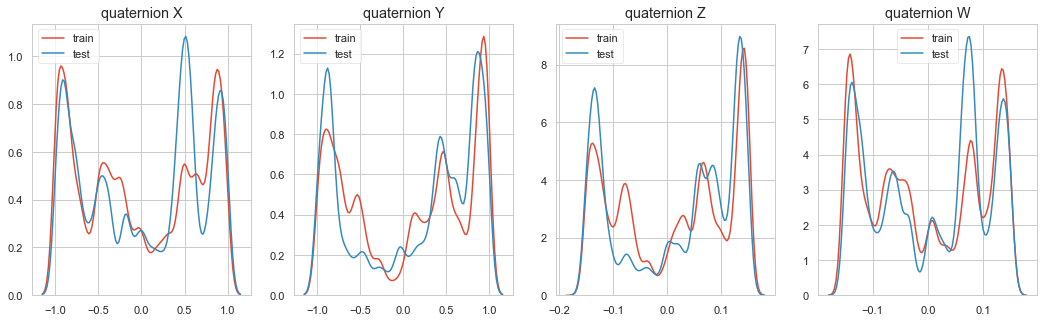

In [52]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18, 5))

ax1.set_title('quaternion X')
sns.kdeplot(data['norm_X'], ax=ax1, label="train")
sns.kdeplot(test['norm_X'], ax=ax1, label="test")

ax2.set_title('quaternion Y')
sns.kdeplot(data['norm_Y'], ax=ax2, label="train")
sns.kdeplot(test['norm_Y'], ax=ax2, label="test")

ax3.set_title('quaternion Z')
sns.kdeplot(data['norm_Z'], ax=ax3, label="train")
sns.kdeplot(test['norm_Z'], ax=ax3, label="test")

ax4.set_title('quaternion W')
sns.kdeplot(data['norm_W'], ax=ax4, label="train")
sns.kdeplot(test['norm_W'], ax=ax4, label="test")

plt.show()

## Step 1: (x, y, z, w) -> (x,y,z)   quaternions to euler angles

In [53]:
def fe_step1 (actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [54]:
data = fe_step1(data)
test = fe_step1(test)
print (data.shape)
data.head()

(487680, 22)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


![](https://d2gne97vdumgn3.cloudfront.net/api/file/UMYT4v0TyIgtyGm8ZXDQ)

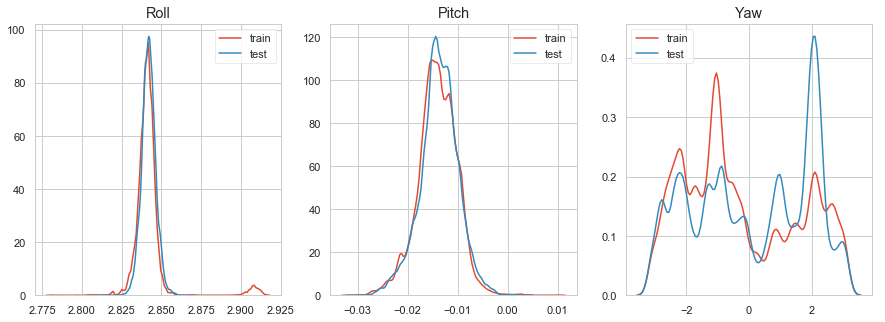

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))

ax1.set_title('Roll')
sns.kdeplot(data['euler_x'], ax=ax1, label="train")
sns.kdeplot(test['euler_x'], ax=ax1, label="test")

ax2.set_title('Pitch')
sns.kdeplot(data['euler_y'], ax=ax2, label="train")
sns.kdeplot(test['euler_y'], ax=ax2, label="test")

ax3.set_title('Yaw')
sns.kdeplot(data['euler_z'], ax=ax3, label="train")
sns.kdeplot(test['euler_z'], ax=ax3, label="test")

plt.show()

**Euler angles** are really important, and we have a problem with Z.

### Why Orientation_Z (euler angle Z) is so important?

We have a robot moving around, imagine a robot moving straight through different surfaces (each with different features), for example concrete and hard tile floor. Our robot can can **bounce** or **balance** itself a little bit on if the surface is not flat and smooth, that's why we need to work with quaternions and take care of orientation_Z.

In [56]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


## Step 2: + Basic features

In [57]:
def feat_eng(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = data.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df
    

In [58]:
%%time
data = feat_eng(data)
test = feat_eng(test)
print ("New features: ",data.shape)

New features:  (3810, 276)
Wall time: 2min 29s


In [59]:
data.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,...,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_range,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_mean_change_of_abs_change,acc_vs_vel_abs_max,acc_vs_vel_abs_min,acc_vs_vel_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000363,0.00131,0.998275,0.000015,2.380952e-07,0.75953,...,995.561076,56.133014,135.641510,939.428062,17.735749,114.896199,1.309785,995.561076,56.133014,525.847045
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.000023,-4.761905e-07,0.95896,...,611.826712,32.938319,88.488750,578.888393,18.574922,57.943094,0.508448,611.826712,32.938319,322.382516
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001377,0.00490,0.990473,0.000041,0.000000e+00,0.51434,...,904.269577,52.834789,132.789650,851.434788,17.115041,83.878164,-0.078679,904.269577,52.834789,478.552183
3,-0.939169,-0.939170,-0.93884,-0.93968,0.000227,0.00084,0.999106,0.000026,-6.349206e-07,0.93968,...,805.924410,11.305069,112.264757,794.619341,71.288762,76.773215,0.928182,805.924410,11.305069,408.614740
4,-0.891301,-0.890940,-0.88673,-0.89689,0.002955,0.01016,0.988672,0.000080,7.936508e-08,0.89689,...,111.588333,39.895232,16.611029,71.693101,2.797034,5.618844,-0.003968,111.588333,39.895232,75.741783


## Correlations (Part II)

In [60]:
#https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr_matrix = data.corr().abs()
raw_corr = data.corr()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
top_corr = pd.DataFrame(sol).reset_index()
top_corr.columns = ["var1", "var2", "abs corr"]
# with .abs() we lost the sign, and it's very important.
for x in range(len(top_corr)):
    var1 = top_corr.iloc[x]["var1"]
    var2 = top_corr.iloc[x]["var2"]
    corr = raw_corr[var1][var2]
    top_corr.at[x, "raw corr"] = corr

In [61]:
top_corr.head(15)

,var1,var2,abs corr,raw corr
0,norm_quat_max,norm_quat_abs_max,1.0,1.0
1,euler_x_max,euler_x_abs_max,1.0,1.0
2,norm_quat_min,norm_quat_abs_min,1.0,1.0
3,acc_vs_vel_max,acc_vs_vel_abs_max,1.0,1.0
4,mod_quat_max,mod_quat_abs_max,1.0,1.0
5,totl_anglr_vel_min,totl_anglr_vel_abs_min,1.0,1.0
6,totl_xyz_max,totl_xyz_abs_max,1.0,1.0
7,euler_x_min,euler_x_abs_min,1.0,1.0
8,totl_xyz_min,totl_xyz_abs_min,1.0,1.0
9,mod_quat_min,mod_quat_abs_min,1.0,1.0


### Filling missing NAs and infinite data ∞  by zeroes 0

In [62]:
data.fillna(0,inplace=True)
test.fillna(0,inplace=True)
data.replace(-np.inf,0,inplace=True)
data.replace(np.inf,0,inplace=True)
test.replace(-np.inf,0,inplace=True)
test.replace(np.inf,0,inplace=True)

## Label encoding

In [69]:
target = pd.read_csv('input/y_train.csv')
target.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [70]:
onehot = pd.get_dummies(target['surface'])
target = onehot.join(target)
target.shape

(3810, 12)

In [84]:
target['surface'] = le.fit_transform(target['surface'])

In [85]:
target['surface'].value_counts()

1    779
5    732
8    607
7    514
2    363
4    308
6    297
0    189
3     21
Name: surface, dtype: int64

In [86]:
target.head()

,carpet,concrete,fine_concrete,hard_tiles,hard_tiles_large_space,soft_pvc,soft_tiles,tiled,wood,series_id,group_id,surface
0,0,0,1,0,0,0,0,0,0,0,13,2
1,0,1,0,0,0,0,0,0,0,1,31,1
2,0,1,0,0,0,0,0,0,0,2,20,1
3,0,1,0,0,0,0,0,0,0,3,31,1
4,0,0,0,0,0,0,1,0,0,4,22,6


In [72]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 12 columns):
carpet                    3810 non-null uint8
concrete                  3810 non-null uint8
fine_concrete             3810 non-null uint8
hard_tiles                3810 non-null uint8
hard_tiles_large_space    3810 non-null uint8
soft_pvc                  3810 non-null uint8
soft_tiles                3810 non-null uint8
tiled                     3810 non-null uint8
wood                      3810 non-null uint8
series_id                 3810 non-null int64
group_id                  3810 non-null int64
surface                   3810 non-null object
dtypes: int64(2), object(1), uint8(9)
memory usage: 122.9+ KB


In [82]:
from sklearn import *
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

#col = ['AUD','CAD','CHF','DKK','EUR','GBP','HKD','JPY','MXN','NOK','NZD','SEK','SGD','USD','backers','usd_pledged_real','usd_goal_real','time_campaign']
#X_train, X_test, y_train, y_test = model_selection.train_test_split(df_ks[col].fillna(-1), df_ks[['canceled','failed','successful']], random_state=1, stratify=df_ks[['canceled','failed','successful']], 
                                                   # test_size=0.25)
#Normalizing the features 
import math
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(data))
X_test_scaled = pd.DataFrame(scaler.transform(test))
print ("Scaled !")

col = ['carpet', 'concrete', 'fine_concrete', 'hard_tiles', 'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled', 'wood']

Scaled !


In [74]:
param_dist = {'objective': 'binary:logistic', 'max_depth': 1, 'n_estimators':1000, 'num_round':1000, 'eval_metric': 'logloss'}
model = multiclass.OneVsRestClassifier(xgb.XGBClassifier(**param_dist))

model.fit(X_train, target[col])

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='logloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, num_round=1000, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          n_jobs=1)

In [77]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)

In [90]:
sub_preds_rf = np.zeros((X_test_scaled.shape[0], 9))
oof_preds_rf = np.zeros((X_train_scaled.shape[0]))
score = 0
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_scaled, target['surface'])):
    clf =  xgb.XGBClassifier(**param_dist)
    clf.fit(X_train_scaled.iloc[trn_idx], target['surface'][trn_idx])
    oof_preds_rf[val_idx] = clf.predict(X_train_scaled.iloc[val_idx])
    sub_preds_rf += clf.predict_proba(X_test_scaled) / folds.n_splits
    score += clf.score(X_train_scaled.iloc[val_idx], target['surface'][val_idx])
    print('Fold: {} score: {}'.format(fold_,clf.score(X_train_scaled.iloc[val_idx], target['surface'][val_idx])))
print('Avg Accuracy', score / folds.n_splits)

Fold: 0 score: 0.8675324675324675
Fold: 1 score: 0.828125
Fold: 2 score: 0.8537859007832899
Fold: 3 score: 0.8586387434554974
Fold: 4 score: 0.863517060367454
Fold: 5 score: 0.8320209973753281
Fold: 6 score: 0.7926509186351706
Fold: 7 score: 0.8443271767810027
Fold: 8 score: 0.8359788359788359


KeyboardInterrupt: 

In [89]:
submission = pd.read_csv('input/sample_submission.csv')
submission['surface'] = le.inverse_transform(sub_preds_rf.argmax(axis=1))
submission.to_csv('submission_rf.csv', index=False)
submission.head(10)

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,concrete
8,8,wood
9,9,wood


# Run Model

**use random_state at Random Forest**

if you don't use random_state you will get a different solution everytime, sometimes you will be lucky, but other times you will lose your time comparing.

**Validation Strategy: Stratified KFold**

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)

In [ ]:
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((data.shape[0]))
score = 0

In [ ]:
from sklearn import *
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
    
    #param_dist = {'objective': 'binary:logistic', 'max_depth': 1, 'n_estimators':1000, 'num_round':1000, 'eval_metric': 'logloss'}
    #model = multiclass.OneVsRestClassifier(xgb.XGBClassifier(**param_dist))
    model = RandomForestClassifier(n_estimators=500, n_jobs = -1)
    #model = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, n_jobs=-1)
    model.fit(data.iloc[trn_idx],target['surface'][trn_idx])
    measured[val_idx] = model.predict(data.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],target['surface'][val_idx])))

    
    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = data.columns
    
    if model.score(data.iloc[val_idx],target['surface'][val_idx]) > 0.92000:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    

    gc.collect()

In [ ]:
print('Avg Accuracy RF', score / folds.n_splits)

In [ ]:
confusion_matrix(measured,target['surface'])

### Confusion Matrix Plot

In [ ]:
# https://www.kaggle.com/artgor/where-do-the-robots-drive

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

In [ ]:
plot_confusion_matrix(target['surface'], measured, le.classes_)

### Submission (Part I)

In [ ]:
sub['surface'] = le.inverse_transform(predicted.argmax(axis=1))
sub.to_csv('submission.csv', index=False)
sub.head()

### Best Submission

In [ ]:
best_sub = pd.read_csv('../input/robots-best-submission/mybest0.73.csv')
best_sub.to_csv('best_submission.csv', index=False)
best_sub.head(10)

## References

[1] https://www.kaggle.com/vanshjatana/help-humanity-by-helping-robots-4e306b

[2] https://www.kaggle.com/artgor/where-do-the-robots-drive

[3] https://www.kaggle.com/gpreda/robots-need-help

[4] https://www.kaggle.com/vanshjatana/help-humanity-by-helping-robots-4e306b by [@vanshjatana](https://www.kaggle.com/vanshjatana)

# ABOUT Submissions & Leaderboard

This kernel [distribution hack](https://www.kaggle.com/donkeys/distribution-hack) by [@donkeys](https://www.kaggle.com/donkeys) simply produces 9 output files, one for each target category. 
I submitted each of these to the competition to see how much of each target type exists in the test set distribution. Results:

- carpet 0.06
- concrete 0.16
- fine concrete 0.09
- hard tiles 0.06
- hard tiles large space 0.10
- soft pvc 0.17
- soft tiles 0.23
- tiled 0.03
- wood 0.06

Also posted a discussion [thread](https://www.kaggle.com/c/career-con-2019/discussion/85204)



**by [@ninoko](https://www.kaggle.com/ninoko)**

I've probed the public leaderboard and this is what I got
There are much less surfaces like wood or tiled, and much more soft and hard tiles in public leaderboard. This can be issue, why CV and LB results differ strangely.

![graph](https://i.imgur.com/DoFc3mW.png)

**I will analyze my best submissions in order to find something interesting.**

Please, feel free to optimize this code.

In [ ]:
sub073 = pd.read_csv('../input/robots-best-submission/mybest0.73.csv')
sub072 = pd.read_csv('../input/robots-best-submission/sub_0.72.csv')
sub072_2 = pd.read_csv('../input/robots-best-submission/sub_0.72_2.csv')
sub071 = pd.read_csv('../input/robots-best-submission/sub_0.71.csv')
sub06 = pd.read_csv('../input/robots-best-submission/sub_0.6.csv')

sub073 = sub073.rename(columns = {'surface':'surface073'})
sub072 = sub072.rename(columns = {'surface':'surface072'})
sub072_2 = sub072_2.rename(columns = {'surface':'surface072_2'})
sub071 = sub071.rename(columns = {'surface':'surface071'})
sub06 = sub06.rename(columns = {'surface':'surface06'})
print ("Submission data is ready")

In [ ]:
sub073.head()

In [ ]:
subtest = pd.concat([sub073['series_id'], sub073['surface073'], sub072['surface072'], sub071['surface071'], sub06['surface06']], axis=1)
subtest.head()

In [ ]:
differents = []
for i in range (0,subtest.shape[0]): 
    labels = list(subtest.iloc[i,1:])
    result = len(set(labels))>1
    if result:
        differents.append((i, str(labels)))
        
differents = pd.DataFrame(differents, columns=['idx','group']) 
differents.head()

For example the serie with **series_id = 2** has the following predicition:

```
['tiled', 'tiled', 'tiled', 'fine_concrete']
```

This means that my best submissions (*0.73, 0.72 and  0.71 LB* ) predicted the same: **tiled**, but a worst submission (*0.6 LB*) would have predicted **fine_concrete**.

---

### So... Why is this interesting?

In order to improve our classification, LB is indicating us wich kind of surfaces are confused with others.
In that example, ```tiled``` and ```fine_concrete``` are being **confused** (maybe because the two surfaces are **alike**)

---

As you can see bellow, we have **177 cases of confusion**
I'm going to plot the tp 10% and see what happens.

In [ ]:
differents['group'].nunique()

In [ ]:
differents['count'] = differents.groupby('group')['group'].transform('count')
differents = differents.sort_values(by=['count'], ascending=False)
differents = differents.drop(['idx'],axis=1)
differents = differents.drop_duplicates()

In [ ]:
differents.head(10)

We can see that **wood** and **fine_concrete** are really hard to guess.

### Maybe this is the most interesting part, the difference between a 0.73 and 0.72 submission.

In [ ]:
differents.tail(10)

Remember the order at the array is [0.73LB, 0.72LB, 0.71LB, 06LB].
Series with ```series_id```= 575, 1024, 911, 723, 148, 338 are really interesting because they show important differences between surfaces that often are being confused.

## Next Step ??

- I will create a test dataset with those special cases and then I will ad a new CV stage where I will try to classify those surfaces correctly.
- I will look for surfaces distinctive features.